# EDA: Tables, Figures, Metrics

Recreate figures, tables, and metrics included in the final report using the data.

### Import Libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from scipy.stats import spearmanr
import seaborn as sns
import sqlite3
import zipfile

%matplotlib inline

### Import Data

Weather Data

In [3]:
conn = sqlite3.connect('../data/weather-data/weather_data.db')
weather_df = pd.read_sql('''select * from weather_data;''', conn)
conn.close()

Crime Data

In [4]:
crime_zip = zipfile.ZipFile('../data/dc-crime-data/dc-crime-data.csv.zip', mode='r')
crime_csv = crime_zip.open('dc-crime-data.csv')
crime_df = pd.read_csv(crime_csv)

Census Data

In [5]:
conn = sqlite3.connect('../data/census-data/census_bg.db')
census_df = pd.read_sql('''select * from census_blockgroup''', conn)
conn.close()

Final Wrangled Data

In [6]:
conn = sqlite3.connect('../data/crime_census_weather_tod.db')

df_all = pd.read_sql('''select * from all_crimes;''', conn)
df_type = pd.read_sql('''select * from by_crime_type;''', conn)

conn.close()

FBI City and National Data

In [7]:
city_path = pathlib.Path("../report/City_Crime_Rates.xlsx")
national_path = pathlib.Path("../report/National_Crime_Rates.xlsx")

In [8]:
fbi_city_cr = pd.read_excel(city_path, sheet_name='data')
fbi_national_cr = pd.read_excel(national_path, sheet_name='data')

## Figure 1

National versus City Violent Crime Rates

#### Data

Create city label.

In [65]:
def create_city(row):
    cl = row['Agency'].split(' ')
    
    if cl[0] == 'Los' or cl[0] == 'Las':
        cty = "{} {}, {}".format(cl[0], cl[1], row['State'])
    elif cl[0] == 'New':
        cty = "{} {} {}, {}".format(cl[0], cl[1], cl[2], row['State'])
    else:
        cty = "{}, {}".format(cl[0], row['State'])
        
    return cty

In [66]:
fbi_city_cr['city'] = fbi_city_cr.apply(create_city, axis=1)

Drop columns and transpose.

In [67]:
fbi_city_cr.drop(columns=['Agency', 'Importance', 'State'], inplace=True)

In [69]:
fbi_city_cr_t = pd.DataFrame(columns=['year','crime_rate','city'])

for index, row in fbi_city_cr.iterrows():
    #Capture city name.
    city = row['city']
    
    #Turn series into dataframe.
    col = row.reset_index()
    
    #Drop where index equals the city name.
    col = col.loc[col['index'] != 'city']
    
    #Create column called city equal to the city name.
    col['city'] = city
    
    #Rename index to year of crime rate and set crime rate values to crime_rate.
    col.rename(columns={'index':'year', list(col.columns)[1]:'crime_rate'}, inplace=True)
    
    #Append to final dataframe.
    fbi_city_cr_t = fbi_city_cr_t.append(other=col, ignore_index=True, sort=False)

#### Plot City and National Data

In [71]:
cities = fbi_city_cr_t['city'].unique()
cities = ['Los Angeles, CA', 'Washington, DC','New York City, NY', 'Philadelphia, PA','Seattle, WA']

In [72]:
fbi_city_cr_t['year'].unique()[0::6]

array([1985, 1991, 1997, 2003, 2009], dtype=object)

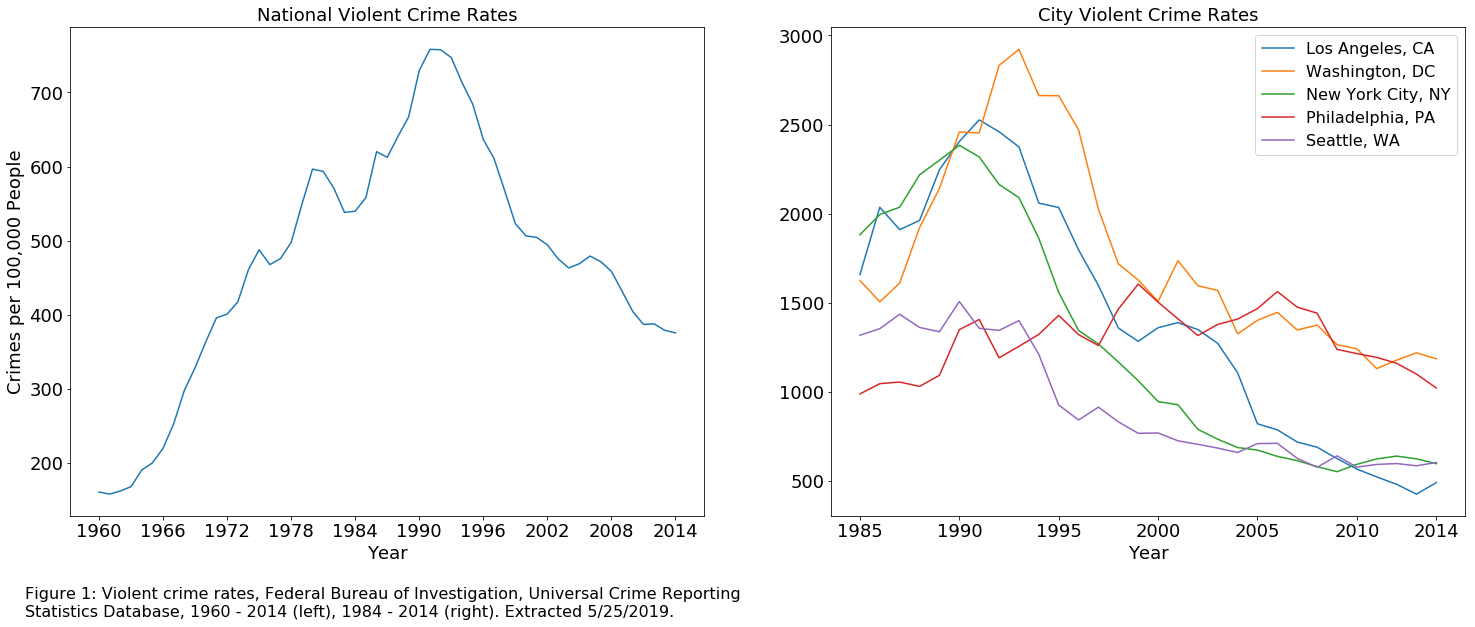

In [74]:
#Create Figure and Axes subplots.
fig = plt.figure(figsize=(25,9))
plt.rc('ytick',labelsize=18)
plt.rc('xtick',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rc('legend', fontsize=16)

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#Edit Text to Figure.
fig.text(0.1, -0.03, 'Figure 1: Violent crime rates, Federal Bureau of Investigation, Universal Crime Reporting \nStatistics Database, \
1960 - 2014 (left), 1984 - 2014 (right). Extracted 5/25/2019.',
         horizontalalignment='left',fontsize=16)

#Left Subplot: Set features (title, y-labels, x-labels, x-ticks).
ax1.title.set_text('National Violent Crime Rates')
ax1.set_ylabel('Crimes per 100,000 People')
ax1.set_xlabel('Year')
ax1.set_xticks(fbi_national_cr['Year'].iloc[0::6])

#Left Subplot: Plot (x-values = year, y-values = violent crime rates).
ax1.plot(fbi_national_cr['Year'], fbi_national_cr['Violent Crime rate'])

#Right Subplot: Set features (title, x-labels, x-ticks)
ax2.title.set_text('City Violent Crime Rates')
ax2.set_xlabel('Year')
ax2.set_xticks([1985, 1990, 1995, 2000, 2005, 2010, 2014])

for city in cities:
    x = fbi_city_cr_t.loc[fbi_city_cr_t['city'] == city, 'year']
    y = fbi_city_cr_t.loc[fbi_city_cr_t['city'] == city, 'crime_rate']

    #Plot Axes 2
    ax2.plot(x,y)

#Set Legend on Axes 2
ax2.legend(cities)

#Export as PNG
fig.savefig('Figure 1.png', bbox_inches='tight')

## Figure 3

Standardizing and Classfying Crime Rates

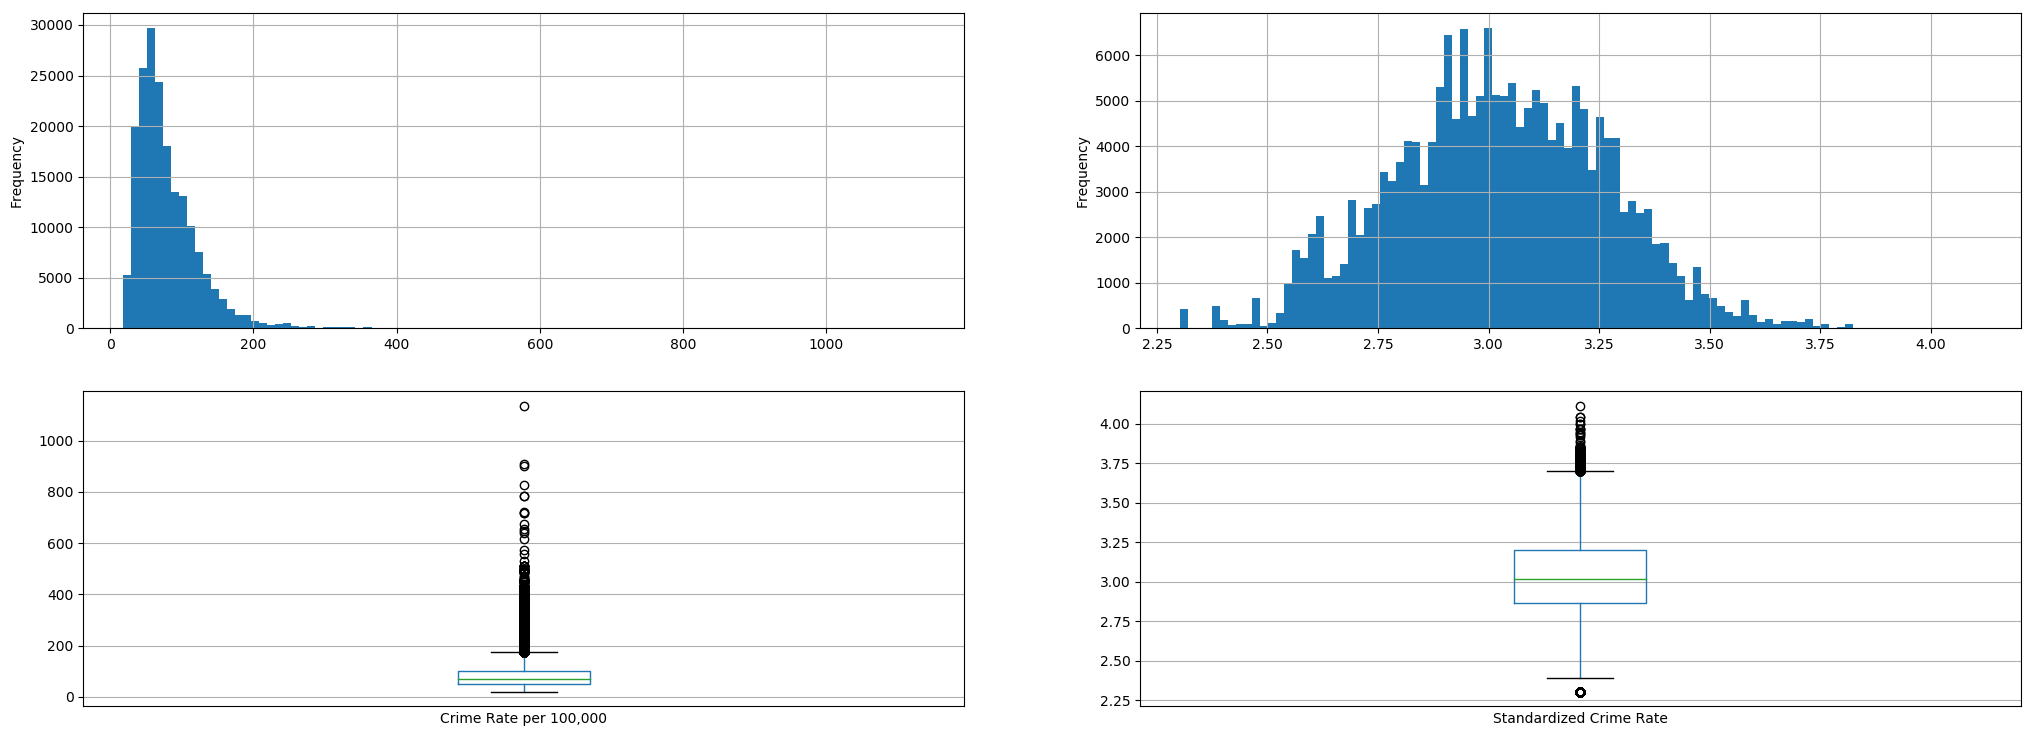

In [139]:
#Create figure.
fig = plt.figure(figsize=(25,9))

#Set 4 subplots.
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

#Use Pandas to plot each.
df_all[['crime_rate']].plot(kind='hist', bins=100, ax=ax1)
df_all[['crs']].plot(kind='hist', bins=100, ax=ax2)
df_all[['crime_rate']].boxplot(ax=ax3)
df_all[['crs']].boxplot(ax=ax4)

#Turn on gid for boxplots.
ax1.grid(b=True)
ax2.grid(b=True)

#Set labels for boxplots.
ax3.get_xaxis().set_ticks([])
ax3.set_xlabel('Crime Rate per 100,000')

ax4.get_xaxis().set_ticks([])
ax4.set_xlabel('Standardized Crime Rate')

ax1.get_legend().remove()
ax2.get_legend().remove()

plt.show()

## Figure 4

Crime Rate Classification

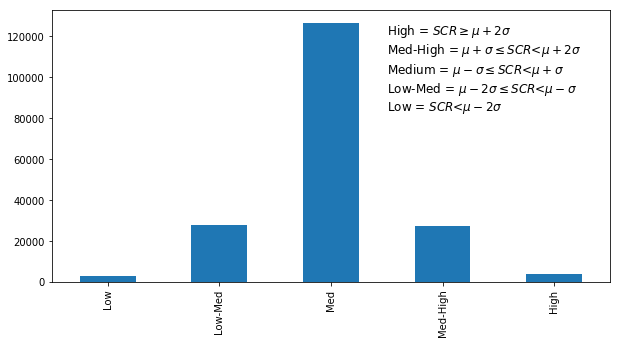

In [66]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1)

bp = df_all['crime_rate_cat'].value_counts().reindex(index=['Low','Low-Med','Med','Med-High','High'])
bp.plot(kind='bar', ax=ax1)

text = 'High = $SCR \geq \mu + 2\sigma$ \n'\
       'Med-High = $\mu + \sigma \leq SCR \less \mu + 2\sigma$ \n'\
       'Medium = $\mu - \sigma \leq SCR \less \mu + \sigma$ \n'\
       'Low-Med = $\mu - 2\sigma \leq SCR \less \mu - \sigma$ \n'\
       'Low = $SCR \less \mu - 2\sigma$'
                   
fig.text(0.59, 0.6, text, horizontalalignment='left', fontsize=12)

plt.show()

# Figure 5

Data

In [23]:
df_all.groupby(by=['tod'])['crime_rate'].median().sort_values()

tod
Late Night       66.511481
Early Morning    67.204301
Midnight         67.340067
Night            68.027211
Morning          68.894247
Mid Afternoon    69.108500
Evening          69.832402
Afternoon        69.881202
Name: crime_rate, dtype: float64

Plot

In [117]:
order = ['Early Morning', 'Morning', 'Afternoon',
         'Mid Afternoon', 'Evening', 'Night',
         'Midnight','Late Night']

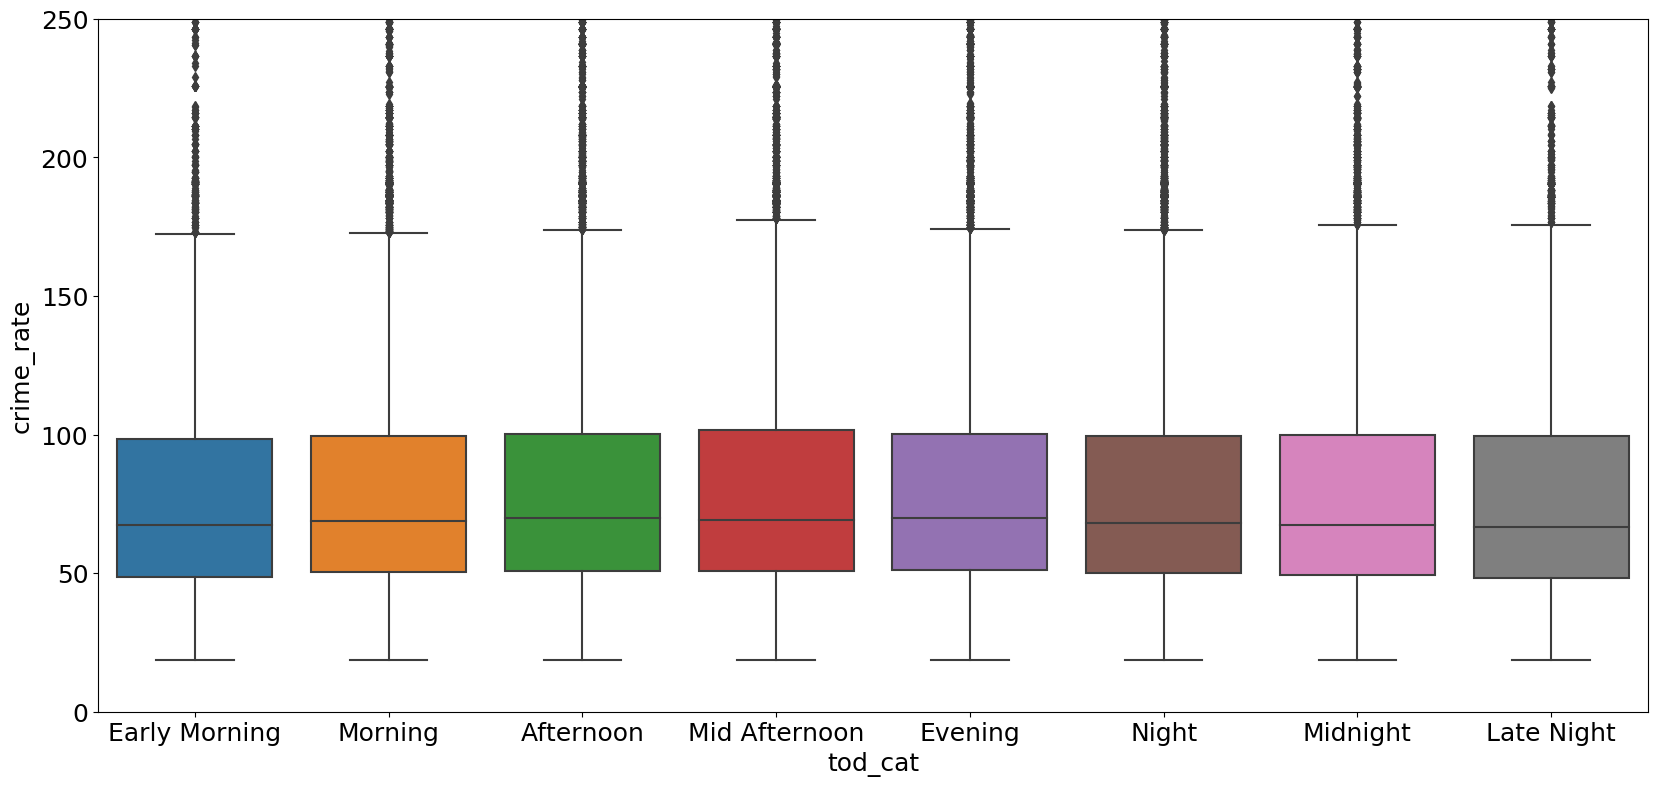

In [119]:
fig = plt.figure(figsize=(20,9))
plt.rc('ytick',labelsize=18)
plt.rc('xtick',labelsize=18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rc('legend', fontsize=16)

ax1 = fig.add_subplot(1,1,1)
ax1.set(ylim=(0,250))

sns.boxplot(x="tod_cat", y="crime_rate", data=df_all, ax=ax1, order=order)

plt.show()

# Figure 6

#### Data

In [24]:
cols = ['crime_rate', 'apparent_temp',
        'percip_probability', 'percip_intensity',
        'uv_index','humidity']

pp = df_all[cols]

In [29]:
print(spearmanr(pp['crime_rate'],pp['percip_intensity']))
print(spearmanr(pp['crime_rate'],pp['percip_intensity']))

SpearmanrResult(correlation=0.9994185638404671, pvalue=0.0)

#### Plot

In [115]:
mpl.rcParams.update(mpl.rcParamsDefault)

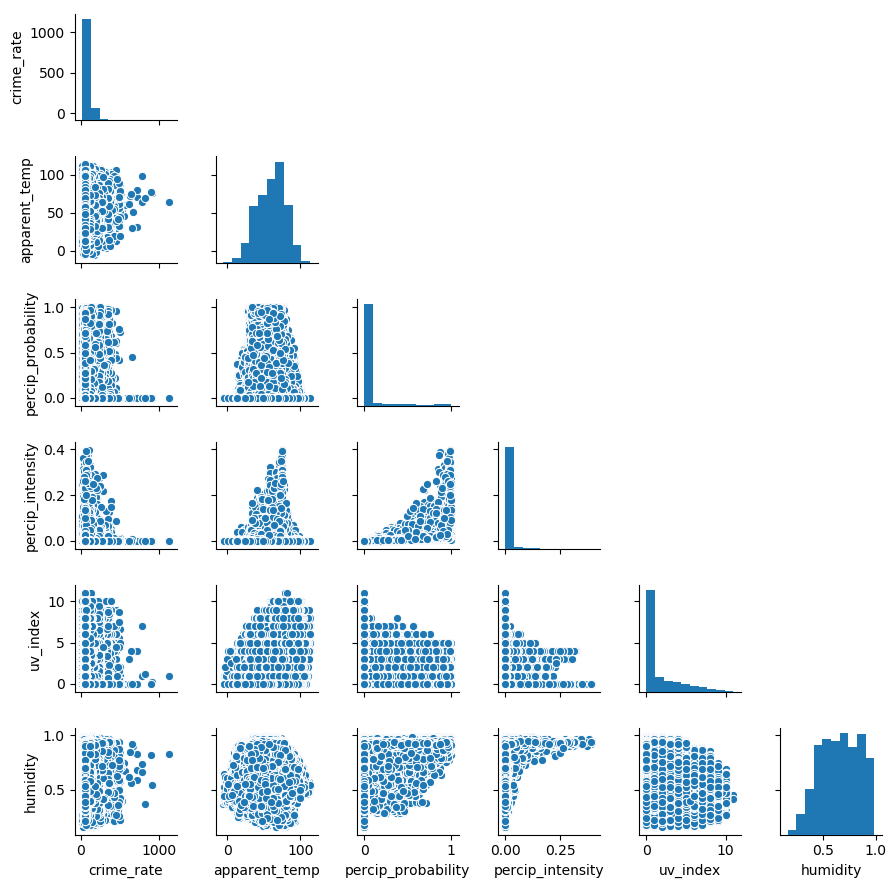

In [44]:
ax = sns.pairplot(pp, height=1.5)

for i, j in zip(*np.triu_indices_from(ax.axes, 1)):
    ax.axes[i, j].set_visible(False)

## Figure X

#### Data

In [100]:
df = df_all.groupby(by=['crime_rate_cat','tod_cat']).agg({'level_0': 'size'})

In [103]:
df = df.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
df.reset_index(inplace=True)

In [112]:
cat_order = ['Early Morning', 'Morning', 'Afternoon', 'Mid Afternoon', 'Evening', 'Night', 'Midnight', 'Late Night']
hue_order = ['Low','Low-Med','Med','Med-High','High']

#### Plot

In [150]:
'''
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

plt.rc('ytick',labelsize=10)
plt.rc('xtick',labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('axes', titlesize=10)
plt.rc('legend', fontsize=10)

sns.catplot(kind='bar', data=df,
            x='tod_cat', y='level_0', hue='crime_rate_cat',
            order=order, hue_order=hue_order, ax=ax)

ax.set_ylabel('% Crimes Reported')
ax.set_xlabel('Crime Rate Classification')
ax.legend(title='Time of Day')

plt.show()
'''

"\nfig = plt.figure(figsize=(10,5))\nax = fig.add_subplot(1,1,1)\n\nplt.rc('ytick',labelsize=10)\nplt.rc('xtick',labelsize=10)\nplt.rc('axes', labelsize=10)\nplt.rc('axes', titlesize=10)\nplt.rc('legend', fontsize=10)\n\nsns.catplot(kind='bar', data=df,\n            x='tod_cat', y='level_0', hue='crime_rate_cat',\n            order=order, hue_order=hue_order, ax=ax)\n\nax.set_ylabel('% Crimes Reported')\nax.set_xlabel('Crime Rate Classification')\nax.legend(title='Time of Day')\n\nplt.show()\n"

## Table 1

Weather Data Summary

In [77]:
pd.options.display.float_format = '{:,.2f}'.format

columns = {'currently_apparentTemperature':'Temperature (Feels-like)',
           'currently_precipIntensity':'Percipitation Intensity',
           'currently_precipProbability':'Precipitation Probability',
           'currently_temperature': 'Temperature'}

table_1 = weather_df.rename(columns=columns)[list(columns.values())].describe()
table_1

,Temperature (Feels-like),Percipitation Intensity,Precipitation Probability,Temperature
count,"379,998.00","379,970.00","379,970.00","379,998.00"
mean,60.52,0.00,0.06,60.26
std,19.21,0.01,0.20,17.66
min,-5.72,0.00,0.00,3.01
25%,45.49,0.00,0.00,46.22
50%,62.22,0.00,0.00,62.17
75%,75.25,0.00,0.00,74.59
max,116.90,0.77,1.00,102.04


## Table 3

Time-of-day Classification

In [78]:
columns = ['Time Classification','Time']

tod = [['Midnight','11pm - 2am'], ['Late Night','2am - 5am'],
       ['Early Morning','5am - 8am'], ['Morning','8am - 11am'],
       ['Afternoon','11am - 2pm'], ['Mid Afternoon','2pm - 5pm'],
       ['Evening','5pm - 8pm'], ['Night', '8pm - 11pm']]

In [79]:
pd.DataFrame(data=tod, columns=columns)

,Time Classification,Time
0,Midnight,11pm - 2am
1,Late Night,2am - 5am
2,Early Morning,5am - 8am
3,Morning,8am - 11am
4,Afternoon,11am - 2pm
5,Mid Afternoon,2pm - 5pm
6,Evening,5pm - 8pm
7,Night,8pm - 11pm


# Table 4

In [60]:
columns = {'crime_rate':'Crime Rate',
           'temperature':'Temperature',
           'percip_probability':'Precipitation Prob',
           'percip_intensity':'Precipitation Intensity',
           'uv_index':'UV Index',
           'PerCapitaIncome':'Per Capita Income',
           'MedianHouseholdInc':'Median Household Income',
           'HousingUnits':'Num Housing Units'}

In [62]:
pd.options.display.float_format = '{:,.2f}'.format

table_4 = df_all.rename(columns=columns)[list(columns.values())].describe()
table_4

,Crime Rate,Temperature,Precipitation Prob,Precipitation Intensity,UV Index,Per Capita Income,Median Household Income,Num Housing Units
count,"188,224.00","188,224.00","188,224.00","188,224.00","188,224.00","188,224.00","188,224.00","188,224.00"
mean,80.65,59.90,0.06,0.00,1.60,"48,633.95","77,993.84",787.20
std,46.18,17.59,0.20,0.01,2.30,"30,614.14","44,770.54",402.79
min,18.49,3.01,0.00,0.00,0.00,"3,787.00","6,548.00",10.00
25%,50.35,46.21,0.00,0.00,0.00,"23,626.00","40,699.00",512.00
50%,68.68,62.04,0.00,0.00,0.00,"42,186.00","72,467.00",692.00
75%,100.00,74.04,0.00,0.00,3.00,"66,392.00","104,950.00",987.00
max,"1,136.36",98.60,1.00,0.40,11.00,"220,398.00","250,001.00","3,325.00"
